<a href="https://colab.research.google.com/github/StanleyLiangYork/TensorFlow_For_Image/blob/master/X_ray_recognition_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use a pretrained Dense Net for Chest X-ray pattern recognition

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import zipfile
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
if not os.path.exists('x_ray_dataset.zip'):
   !gsutil cp gs://pet-detect-239118/x_ray_dataset.zip ./x_ray_dataset.zip
   # use zipfile to unzip has less printout
   
with zipfile.ZipFile('x_ray_dataset.zip') as zipObj:
  zipObj.extractall()

Copying gs://pet-detect-239118/x_ray_dataset.zip...
\ [1 files][624.9 MiB/624.9 MiB]                                                
Operation completed over 1 objects/624.9 MiB.                                    


Import the utility functions

In [3]:
import shutil

source_path = '/content/x_ray_dataset/util.py'
target_path = 'util.py'
shutil.move(source_path, target_path)

'util.py'

In [4]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_patients_unique = set(df1[patient_col].values)
    df2_patients_unique = set(df2[patient_col].values)
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    n_overlap = len(patients_in_both_groups)
    leakage = True if n_overlap > 0 else False
    
    return leakage, patients_in_both_groups

In [5]:
train_df = pd.read_csv("/content/x_ray_dataset/train-small.csv")
valid_df = pd.read_csv("/content/x_ray_dataset/valid-small.csv")
test_df = pd.read_csv("/content/x_ray_dataset/test.csv")

In [6]:
leak, patient_id = check_for_leakage(train_df, test_df, 'PatientId')
leak_2, patient_id_2 = check_for_leakage(valid_df, test_df, 'PatientId')
leak_3, patient_id_3 = check_for_leakage(train_df, valid_df, 'PatientId')
print(f"train-test overlap: {leak}")
print(f"validation-test overlap: {leak_2}")
print(f"train-validation overlap: {leak_3}")

train-test overlap: False
validation-test overlap: False
train-validation overlap: True


Set the image preprocessing functions

In [7]:
# decode image from file
def decode_img(image, preprocess=True):
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
  if preprocess:
    image = tf.image.per_image_standardization(image)
    return image
  else:
    return image


# for the entrance of the the mapping function, use two arguments
# the labels should be cast to float32 for weighting
def preprocessing_img(file_path,labels):
   img = tf.io.read_file(file_path)
   img = decode_img(img)
   labels = tf.cast(labels, dtype='float32')
   return img, labels

In [8]:
train_img_df = train_df.pop('Image')
test_img_df = test_df.pop('Image')
val_img_df = valid_df.pop('Image')

# take the label list
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

train_label_df = train_df[labels]
test_label_df = test_df[labels]
val_label_df = valid_df[labels]

In [9]:
# a dictionary in {'label_name': index}
def get_label_idx(labels):
  label_dict = dict()
  for i, label in enumerate(labels):
    label_dict[label] = i

  return label_dict

In [45]:
label_idx = get_label_idx(labels)

In [46]:
for k,v in label_idx.items():
  print(f'key: {k}, value: {v}')

key: Cardiomegaly, value: 0
key: Emphysema, value: 1
key: Effusion, value: 2
key: Hernia, value: 3
key: Infiltration, value: 4
key: Mass, value: 5
key: Nodule, value: 6
key: Atelectasis, value: 7
key: Pneumothorax, value: 8
key: Pleural_Thickening, value: 9
key: Pneumonia, value: 10
key: Fibrosis, value: 11
key: Edema, value: 12
key: Consolidation, value: 13


In [12]:
root_path = '/content/x_ray_dataset/images/'
train_files = root_path + train_img_df.values
test_files = root_path + test_img_df.values
val_files = root_path + val_img_df.values

Load the image file names

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_label_df.values))
test_ds =  tf.data.Dataset.from_tensor_slices((test_files, test_label_df.values))
val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_label_df.values))

print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

1000
420
200


Load the image tensors

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(preprocessing_img, num_parallel_calls=AUTOTUNE).cache().shuffle(1000).batch(20)
test_ds = test_ds.map(preprocessing_img, num_parallel_calls=AUTOTUNE).cache().shuffle(420).batch(20)
val_ds = val_ds.map(preprocessing_img, num_parallel_calls=AUTOTUNE).cache().shuffle(200).batch(20)

Get an image patch

In [15]:
image, label = next(iter(train_ds))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Atelectasis ')

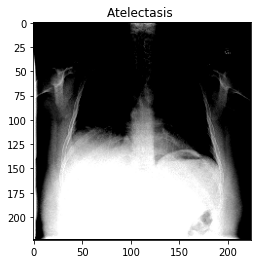

In [16]:
label_code = label[0].numpy()
titles = ''
for i, item in enumerate(label_code):
  if item == 1:
    titles += labels[i]+' '
if titles == '':
  titles = 'Normal'

plt.imshow(image[0,:,:,:])
plt.title(titles)

Show the normalized image, where the pixel values are in normal distribution

Text(0, 0.5, '# Pixels in Image')

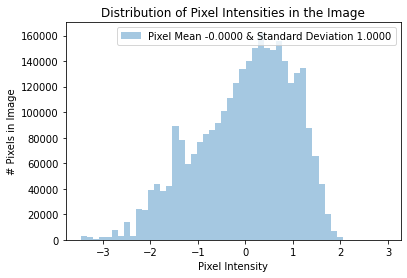

In [17]:
# Plot a histogram of the distribution of the pixels
shown_img = image.numpy()
sns.distplot(shown_img.ravel(), 
             label=f'Pixel Mean {np.mean(shown_img):.4f} & Standard Deviation {np.std(shown_img):.4f}', kde=False)
plt.legend(loc='best')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

Use the Dense Net 121 architecture with the pretrained weights

In [18]:
label_idx

{'Atelectasis': 7,
 'Cardiomegaly': 0,
 'Consolidation': 13,
 'Edema': 12,
 'Effusion': 2,
 'Emphysema': 1,
 'Fibrosis': 11,
 'Hernia': 3,
 'Infiltration': 4,
 'Mass': 5,
 'Nodule': 6,
 'Pleural_Thickening': 9,
 'Pneumonia': 10,
 'Pneumothorax': 8}

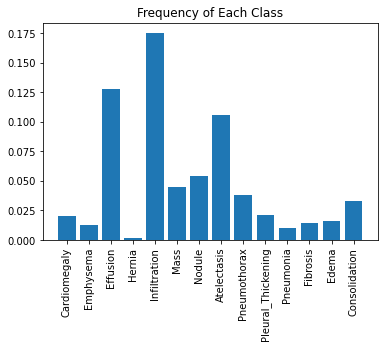

In [19]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_df[labels].values, axis=0))
plt.title("Frequency of Each Class")
plt.show()

show the frequency (in percentage) of each class, all are low in possitive, so the classifer can merely guess negative for a very high overal accuracy <p>
Therefore, we need to weight the loss by the corresponding frequency of each class

In [20]:
def compute_class_freqs(labels):
    """
    Compute positive and negative frequences in percentage for each class.

    Args:
        labels (np.array): matrix of labels, size (num_examples, num_classes)
    Returns:
        positive_frequencies (np.array): array of positive frequences for each
                                         class, size (num_classes)
        negative_frequencies (np.array): array of negative frequences for each
                                         class, size (num_classes)
    """
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = (N-np.sum(labels, axis=0)) / N

    return positive_frequencies, negative_frequencies

In [21]:
freq_pos, freq_neg = compute_class_freqs(train_df[labels].values)

print(f"positive: {freq_pos}")
print(f"negative: {freq_neg}")

positive: [0.02  0.013 0.128 0.002 0.175 0.045 0.054 0.106 0.038 0.021 0.01  0.014
 0.016 0.033]
negative: [0.98  0.987 0.872 0.998 0.825 0.955 0.946 0.894 0.962 0.979 0.99  0.986
 0.984 0.967]


Text(0.5, 1.0, 'Original frequency')

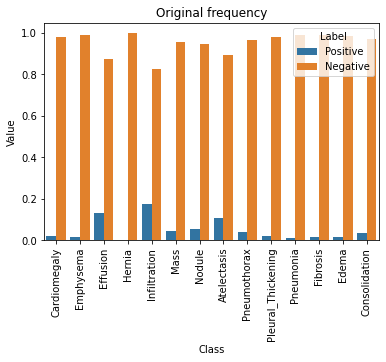

In [22]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)
plt.title("Original frequency")

To let the contributions be equal. we can multiply each example from each class by a class-specific weight factor, $w_{pos}$ and $w_{neg}$, so that the overall contribution of each class is the same. 

If we want 

$w_{pos} \times freq_{pos} = w_{neg} \times freq_{neg},$

we can let

$w_{pos} = freq_{neg}$<p>
$w_{neg} = freq_{pos}$


In [23]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Text(0.5, 1.0, 'Weighted Label Frequency')

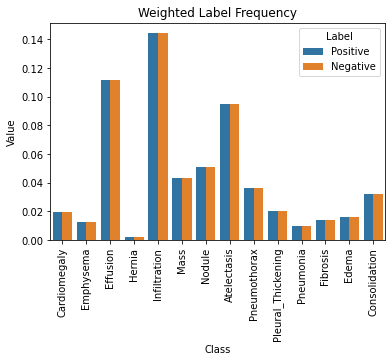

In [24]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);
plt.title('Weighted Label Frequency')

The final weighted loss for each training case is defined as: 

$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$

In [25]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    # use the internal function to return the general format for keras loss function
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (Float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss_pos = -1 * tf.reduce_mean(pos_weights[i] * y_true[:,i] * tf.math.log(y_pred[:,i] + epsilon))
            loss_neg = -1 * tf.reduce_mean(neg_weights[i] * (1 - y_true[:,i]) * tf.math.log( 1- y_pred[:,i]+epsilon))
            loss += loss_pos+loss_neg
            #complete this line
        return loss
    
    return weighted_loss

Define the dense net model with the pretrained weights

In [29]:
# create the base pre-trained model
base_model = DenseNet121(weights='/content/x_ray_dataset/densenet.hdf5', include_top=False)
base_model.trainable = True

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=tf.optimizers.Adam(learning_rate=2e-3), loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])
model.load_weights("/content/x_ray_dataset/pretrained_model.h5")

In [30]:
checkpoint_dir = './train_checkpoints'  
# don't use checkpoint or checkpoints as the folder name, they are reserved by TF
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_freq=20)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)

In [31]:
history = model.fit(train_ds, validation_data=val_ds, callbacks=[checkpoint_callback, reduce_lr], epochs=100,verbose=2)

Epoch 1/100
50/50 - 8s - loss: 0.7193 - accuracy: 0.1390 - val_loss: 3.5900 - val_accuracy: 0.0900
Epoch 2/100
50/50 - 7s - loss: 0.5935 - accuracy: 0.1900 - val_loss: 0.7119 - val_accuracy: 0.1800
Epoch 3/100
50/50 - 6s - loss: 0.5247 - accuracy: 0.1910 - val_loss: 0.5623 - val_accuracy: 0.1800
Epoch 4/100
50/50 - 7s - loss: 0.5062 - accuracy: 0.1830 - val_loss: 0.7035 - val_accuracy: 0.1800
Epoch 5/100
50/50 - 6s - loss: 0.4478 - accuracy: 0.2210 - val_loss: 0.5962 - val_accuracy: 0.1900
Epoch 6/100
50/50 - 7s - loss: 0.3845 - accuracy: 0.2200 - val_loss: 0.4627 - val_accuracy: 0.2650
Epoch 7/100
50/50 - 6s - loss: 0.3138 - accuracy: 0.2750 - val_loss: 0.5957 - val_accuracy: 0.1050
Epoch 8/100
50/50 - 6s - loss: 0.2959 - accuracy: 0.2750 - val_loss: 0.4764 - val_accuracy: 0.2250
Epoch 9/100
50/50 - 6s - loss: 0.3114 - accuracy: 0.2920 - val_loss: 0.4819 - val_accuracy: 0.2750
Epoch 10/100

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
50/50 - 6s - lo

In [32]:
model.save_weights('train_100_epoch.h5')

In [38]:
def summarize_diagnostics(history):
  plt.figure(figsize=(10, 10))
  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], color='blue', label='Training')
  plt.plot(history.history['val_loss'], color='orange', label='Test')
  plt.legend(loc='best')
  plt.title('Cross Entropy Loss')
  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], color='blue', label='Training')
  plt.plot(history.history['val_accuracy'], color='orange', label='Test')
  plt.legend(loc='best')
  plt.title('Classification Accuracy')
  plt.show()

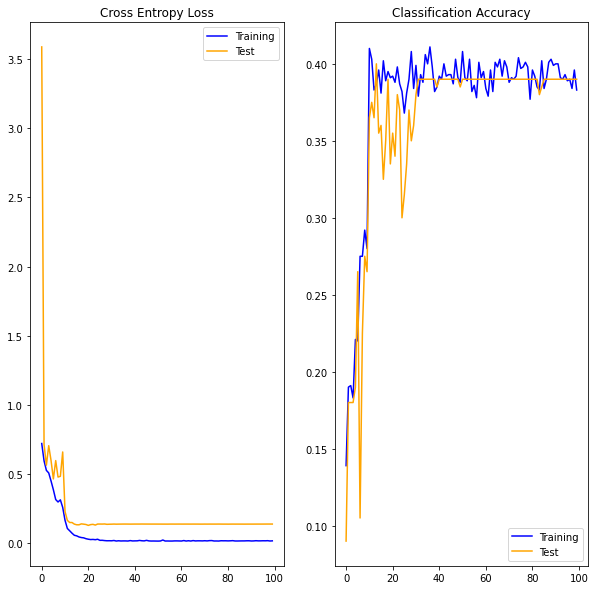

In [39]:
summarize_diagnostics(history)

In [41]:
model.load_weights("/content/train_100_epoch.h5")

predicted_vals = model.predict(test_ds)

In [42]:
probs = tf.nn.softmax(predicted_vals, axis=-1)

In [43]:
probs.shape[1]

14

In [48]:
label_shown = ['Pneumothorax', 'Nodule', 'Cardiomegaly', 'Mass']
show_idx = [ label_idx[i] for i in label_shown]

show_idx

[8, 6, 0, 5]

Compute the ROC score and AUC

In [49]:
from sklearn.metrics import roc_auc_score, roc_curve


def comput_roc_auc_score(predict_logits, ds):
    auc_roc_vals = []
    test_labels = []
    for batch in iter(ds):
    # the second element is the label
      for item in batch[1]:
        test_labels.append(item.numpy())
    
    test_labels = tf.convert_to_tensor(test_labels)
    
    for i in range(test_labels.shape[1]):
      gt = test_labels[:,i] # ground true
      pred = predict_logits[:,i]
      auc_roc = roc_auc_score(gt, pred)
      auc_roc_vals.append(auc_roc)

    return auc_roc_vals


# def get_label_idx(show_label, labels):
#   label_dict = {}
#   label_out = []
#   for i, l in enumerate(labels):
#     label_dict[l] = i
#   for l in show_label:
#     label_out.append(label_dict[l])
#   return label_out



def plot_roc(predict_logits, ds, labels):
  test_labels = []
  auc_roc_scores = []
  for batch in iter(ds):
    # the second element is the label
    for item in batch[1]:
      test_labels.append(item.numpy())
  
  test_labels = tf.convert_to_tensor(test_labels)
  
  for i in range(len(labels)):
    gt = test_labels[:,i] # ground true
    pred = predict_logits[:,i]
    auc_roc = roc_auc_score(gt, pred)
    fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
    plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label=labels[i] + "("+str(round(auc_roc,3))+")")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')


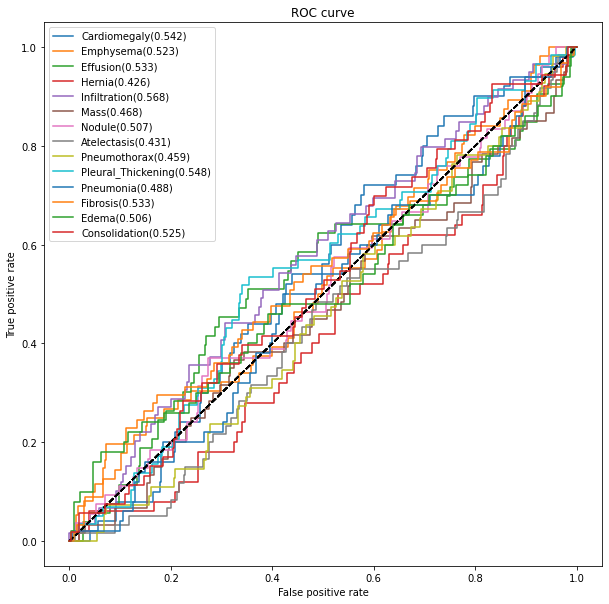

In [50]:
plot_roc(probs, test_ds, labels)

Show the top K ROC

In [51]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_k_roc(predict_logits, ds, labels, label_idx):
  test_labels = []
  for batch in iter(ds):
    # the second element is the label
    for item in batch[1]:
      test_labels.append(item.numpy())

  test_labels = tf.convert_to_tensor(test_labels)
  for i in label_idx:
    gt = test_labels[:,i]
    pred = predict_logits[:,i]
    auc_roc = roc_auc_score(gt, pred)
    fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
    plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rf, tpr_rf, label=labels[i] + "("+str(round(auc_roc,3))+")")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')


In [59]:
auc_roc_scores = comput_roc_auc_score(probs, test_ds)

In [155]:
labels_to_show = np.take(labels, np.argsort(auc_roc_scores)[::-1])[:5]

In [156]:
labels_to_show

array(['Cardiomegaly', 'Effusion', 'Pleural_Thickening', 'Mass', 'Edema'],
      dtype='<U18')

In [62]:
show_idx = [label_idx[i] for i in labels_to_show]

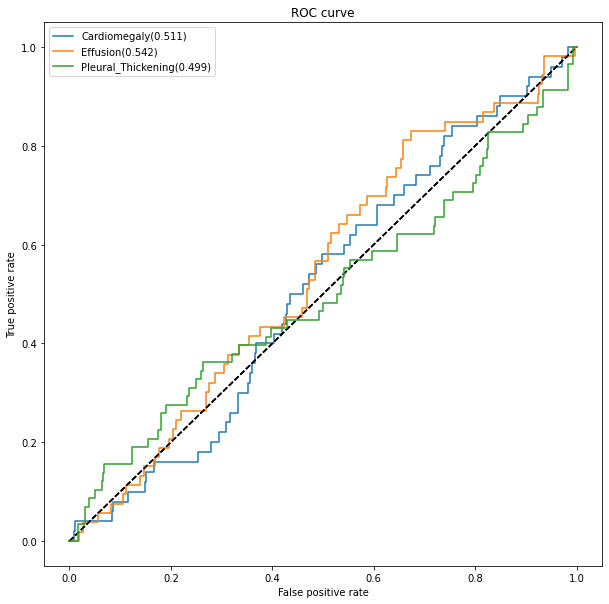

In [63]:
plot_k_roc(probs, test_ds, labels, show_idx)

Compute the Grad-CAM

In [115]:
def load_image_gradCAM(img_file, image_dir, preprocess=True, H=224, W=224):
    """Load and preprocess image."""
    img_path = image_dir + img_file
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize_with_pad(image, target_height=H, target_width=W)
    if preprocess == True:
      image = tf.image.per_image_standardization(image)
      image = tf.expand_dims(image, axis=0)
      
    return image

In [116]:
image_file = '00008270_015.png'
image_dir = '/content/x_ray_dataset/images/'

process_input = load_image_gradCAM(image_file, image_dir)

In [117]:
logits = model(process_input)
probs = tf.nn.softmax(logits)

In [118]:
grad_model = Model(inputs=model.input, outputs=[model.get_layer('bn').output, model.output])

In [119]:
def compute_gradients(images, model, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    conv_output, logits = model(images)
    grads = tape.gradient(logits[0,target_class_idx], conv_output)
    return conv_output[0], grads[0]

**Return** the Grad-CAM images for each class.

    Args:
      image_file (string): the image file name, if it is jpeg, change the load_image_gradCAM function to decode_jpeg
      image_dir (string): the path of the image file
      model (tf model): the trained model
      layer_name (tf layer): the layer to be produce the gradient
      all_labels (list): a list of all label names corresponding to the output
      label_to_show (list): a list of labels to be shown
    
    requires:
      the load_image_gradCAM function and the compute_gradients function
    """

In [162]:
def show_Grad_CAM(image_file, image_dir, model, layer_name, all_labels, label_to_show):
  process_input = load_image_gradCAM(image_file, image_dir)
  logits = model(process_input)
  probs = tf.nn.softmax(logits)
  grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])
  label_idx = {v:k for (k,v) in enumerate(labels)}

  plt.figure(figsize=(16, 16))
  n = len(labels_to_show)

  for i, label in enumerate(label_to_show):
    show_index = label_idx[label]
    output, grads = compute_gradients(process_input, grad_model, show_index)
    weights = np.mean(grads, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (224, 224), cv2.INTER_LINEAR)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    show_image = load_image_gradCAM(image_file, image_dir, preprocess=False)
    ax = plt.subplot(n, 1, i+1)
    ax.imshow(show_image, cmap='gray')
    ax.imshow(cam, cmap='jet', alpha=0.3)
    plt.title(label)
    ax.axis(False)
      
  plt.tight_layout()


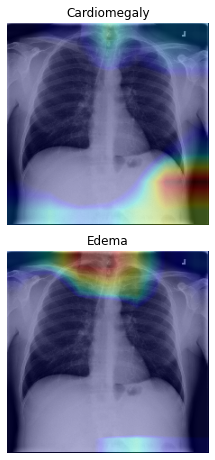

In [163]:
image_file = '00008270_015.png'
image_dir = '/content/x_ray_dataset/images/'

show_Grad_CAM(image_file, image_dir, model, 'bn', labels, label_to_show=['Cardiomegaly', 'Edema'])

In [164]:
labels

['Cardiomegaly',
 'Emphysema',
 'Effusion',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Atelectasis',
 'Pneumothorax',
 'Pleural_Thickening',
 'Pneumonia',
 'Fibrosis',
 'Edema',
 'Consolidation']

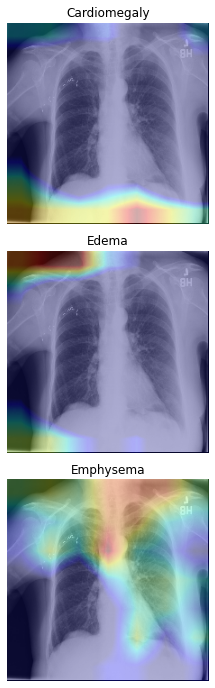

In [165]:
image_file = '00000003_001.png'
image_dir = '/content/x_ray_dataset/images/'

show_Grad_CAM(image_file, image_dir, model, 'bn', labels, label_to_show=['Cardiomegaly', 'Edema', 'Emphysema'])

**Compute IG (integrated gradients) graph**

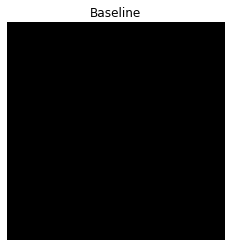

In [166]:
baseline = tf.zeros(shape=(224,224,3))
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [167]:
m_steps=50
# Generate m_steps intervals for integral_approximation() below.
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) 

def interpolate_images(baseline,image,alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images


In [168]:
interpolated_images = interpolate_images(
    baseline=baseline,
    image=load_image_gradCAM(image_file, image_dir, preprocess=False),
    alphas=alphas)

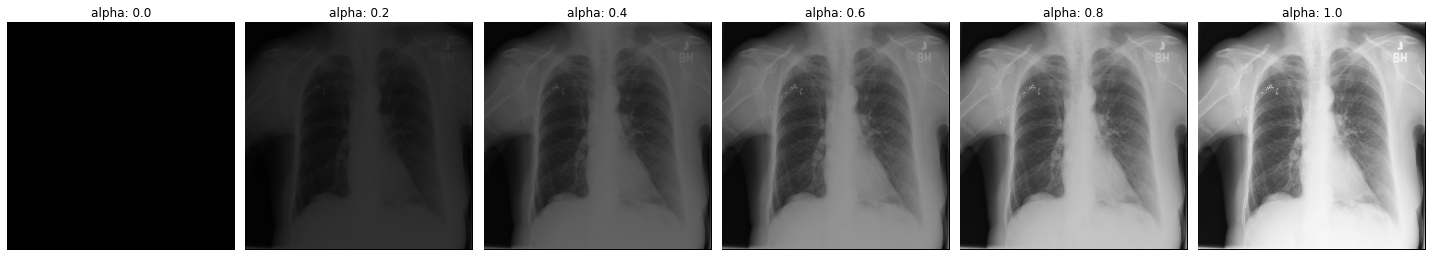

In [169]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

In [170]:
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

In [171]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=0)

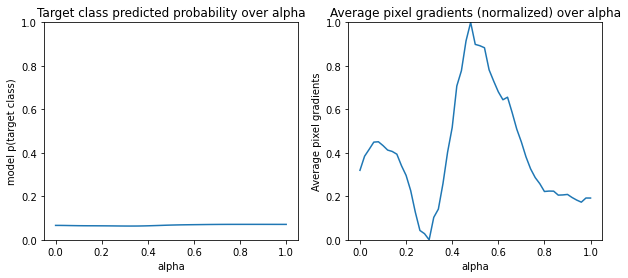

In [173]:
pred = model(interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 0]

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

In [174]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

In [175]:
ig = integral_approximation(
    gradients=path_gradients)

In [177]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [178]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       image=load_image_gradCAM(image_file, image_dir, preprocess=False),
                                       target_class_idx=0,
                                       m_steps=240)

In [181]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

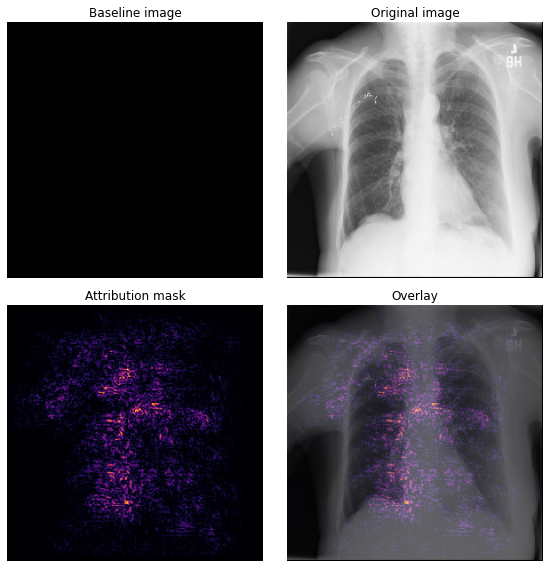

In [184]:
_ = plot_img_attributions(image=load_image_gradCAM(image_file, image_dir, preprocess=False),
                          baseline=baseline,
                          target_class_idx=0,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)